In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 772ms/step - loss: 0.5132
Average validation loss: 0.6133545637130737
4/4 [==============================] - 7s 786ms/step - loss: 0.5132 - val_loss: 0.6134
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 774ms/step - loss: 0.4038 - val_loss: 0.6134
Average validation loss: 0.42995959520339966
4/4 [==============================] - 10s 794ms/step - loss: 0.4038 - val_loss: 0.5217
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 14s 779ms/step - loss: 0.3154 - val_loss: 0.5217
Average validation loss: 0.377993643283844
4/4 [==============================] - 14s 792ms/step - loss: 0.3154 - val_loss: 0.4738
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 787ms/step - loss: 0.0260
Average validation loss: 0.0
8/8 [==============================] - 6s 801ms/step - loss: 0.0260 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 791ms/step - loss: 0.0253 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 13s 804ms/step - loss: 0.0253 - val_loss: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 19s 794ms/step - loss: 0.0250 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 19s 807ms/step - loss: 0.0250 - val_loss: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 26s 788ms/step - loss: 0.0246 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 26s 802ms/step - loss: 0.0246 - val_loss: 0.0000e+00


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 815ms/step - loss: 0.0289
Average validation loss: 0.02862655829327802
12/12 [==============================] - 10s 826ms/step - loss: 0.0289 - val_loss: 0.0286
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 20s 832ms/step - loss: 0.0293 - val_loss: 0.0286
Average validation loss: 0.09185239672660828
12/12 [==============================] - 20s 844ms/step - loss: 0.0293 - val_loss: 0.0602
Epoch 3/10
12/12 [==============================] - 30s 798ms/step - loss: 0.0288 - val_loss: 0.0602
Average validation loss: 0.12570405999819437
12/12 [==============================] - 30s 810ms/step - loss: 0.0288 - val_loss: 0.0821
Epoch 4/10
12/12 [==============================] - 39s 783ms/step - loss: 0.0287 - val_loss: 0.0821
Average validation loss: 0.1484966278076172
12/12 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 13s 797ms/step - loss: 0.0280
Average validation loss: 0.2919500619362623
16/16 [==============================] - 13s 810ms/step - loss: 0.0280 - val_loss: 0.2920
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 26s 810ms/step - loss: 0.0270 - val_loss: 0.2920
Average validation loss: 0.09368003106362721
16/16 [==============================] - 26s 822ms/step - loss: 0.0270 - val_loss: 0.1928
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 39s 799ms/step - loss: 0.0266 - val_loss: 0.1928
Average validation loss: 0.051747292436175485
16/16 [==============================] - 39s 813ms/step - loss: 0.0266 - val_loss: 0.1458
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 16s 786ms/step - loss: 0.0166
Average validation loss: 0.2869122982025146
20/20 [==============================] - 16s 800ms/step - loss: 0.0166 - val_loss: 0.2869
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 32s 786ms/step - loss: 0.0156 - val_loss: 0.2869
Average validation loss: 0.18845275417251628
20/20 [==============================] - 32s 800ms/step - loss: 0.0156 - val_loss: 0.2377
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 48s 784ms/step - loss: 0.0151 - val_loss: 0.2377
Average validation loss: 0.061257405021501656
20/20 [==============================] - 48s 798ms/step - loss: 0.0151 - val_loss: 0.1789
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 745ms/step - loss: 0.0166
Average validation loss: 0.7251427372296652
24/24 [==============================] - 18s 758ms/step - loss: 0.0166 - val_loss: 0.7251
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 716ms/step - loss: 0.0157 - val_loss: 0.7251
Average validation loss: 0.044931468243400254
24/24 [==============================] - 36s 728ms/step - loss: 0.0157 - val_loss: 0.3850
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 732ms/step - loss: 0.0153 - val_loss: 0.3850
Average validation loss: 0.8378886083761851
24/24 [==============================] - 54s 745ms/step - loss: 0.0153 - val_loss: 0.5360
Epoch 4/10
24/24 [=========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 723ms/step - loss: 0.0232
Average validation loss: 0.11640361435711384
40/40 [==============================] - 29s 735ms/step - loss: 0.0232 - val_loss: 0.1164
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 716ms/step - loss: 0.0209 - val_loss: 0.1164
Average validation loss: 0.28333736658096315
40/40 [==============================] - 59s 728ms/step - loss: 0.0209 - val_loss: 0.1999
Epoch 3/10
40/40 [==============================] - 88s 742ms/step - loss: 0.0197 - val_loss: 0.1999
Average validation loss: 0.5681192338466644
40/40 [==============================] - 89s 753ms/step - loss: 0.0197 - val_loss: 0.3226
Epoch 4/10
40/40 [==============================] - 118s 722ms/step - loss: 0.0190 - val_loss: 0.3226
Average validation loss: 0.2955355763435364
40/40 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 722ms/step - loss: 0.0140
Average validation loss: 0.03883316340450923
48/48 [==============================] - 35s 734ms/step - loss: 0.0140 - val_loss: 0.0388
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 729ms/step - loss: 0.0121 - val_loss: 0.0388
Average validation loss: 0.05773569206620081
48/48 [==============================] - 71s 740ms/step - loss: 0.0121 - val_loss: 0.0483
Epoch 3/10
48/48 [==============================] - 106s 732ms/step - loss: 0.0113 - val_loss: 0.0483
Average validation loss: 0.04653263776951159
48/48 [==============================] - 106s 743ms/step - loss: 0.0113 - val_loss: 0.0477
Epoch 4/10
48/48 [==============================] - 142s 738ms/step - loss: 0.0106 - val_loss: 0.0477
Average validation loss: 0.040301706963711124
48/48 [=========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 722ms/step - loss: 0.0162
Average validation loss: 0.06550483760587482
56/56 [==============================] - 41s 734ms/step - loss: 0.0162 - val_loss: 0.0655
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 725ms/step - loss: 0.0131 - val_loss: 0.0655
Average validation loss: 0.02287599123577014
56/56 [==============================] - 82s 737ms/step - loss: 0.0131 - val_loss: 0.0442
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 123s 726ms/step - loss: 0.0113 - val_loss: 0.0442
Average validation loss: 0.02175581761776511
56/56 [==============================] - 124s 738ms/step - loss: 0.0113 - val_loss: 0.0367
Saved model weights to 'c:\Users\user\De

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 724ms/step - loss: 0.0145
Average validation loss: 0.02229122609423939
64/64 [==============================] - 47s 735ms/step - loss: 0.0145 - val_loss: 0.0223
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 721ms/step - loss: 0.0110 - val_loss: 0.0223
Average validation loss: 0.014458559220656753
64/64 [==============================] - 94s 733ms/step - loss: 0.0110 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 141s 725ms/step - loss: 0.0097 - val_loss: 0.0184
Average validation loss: 0.016933403428993188
64/64 [==============================] - 141s 737ms/step - loss: 0.0097 - val_loss: 0.0179
Epoch 4/10
64/64 [====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 721ms/step - loss: 0.0114
Average validation loss: 0.015224783707203137
72/72 [==============================] - 53s 732ms/step - loss: 0.0114 - val_loss: 0.0152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 719ms/step - loss: 0.0086 - val_loss: 0.0152
Average validation loss: 0.009991269481057921
72/72 [==============================] - 105s 730ms/step - loss: 0.0086 - val_loss: 0.0126
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 726ms/step - loss: 0.0077 - val_loss: 0.0126
Average validation loss: 0.019491284826977387
72/72 [==============================] - 159s 738ms/step - loss: 0.0077 - val_loss: 0.0149
Epoch 4/10
72/72 [=================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 720ms/step - loss: 0.0120
Average validation loss: 0.014645495475269854
80/80 [==============================] - 58s 731ms/step - loss: 0.0120 - val_loss: 0.0146
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 730ms/step - loss: 0.0089 - val_loss: 0.0146
Average validation loss: 0.04506831793114543
80/80 [==============================] - 118s 741ms/step - loss: 0.0089 - val_loss: 0.0299
Epoch 3/10
80/80 [==============================] - 177s 733ms/step - loss: 0.0074 - val_loss: 0.0299
Average validation loss: 0.03333950145170093
80/80 [==============================] - 178s 745ms/step - loss: 0.0074 - val_loss: 0.0310
Epoch 4/10
80/80 [==============================] - 236s 729ms/step - loss: 0.0065 - val_loss: 0.0310
Average validation loss: 0.0076833044295199215
80/80 [====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 717ms/step - loss: 0.0146
Average validation loss: 0.1430330753370678
96/96 [==============================] - 70s 729ms/step - loss: 0.0146 - val_loss: 0.1430
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 718ms/step - loss: 0.0117 - val_loss: 0.1430
Average validation loss: 0.027181493998796213
96/96 [==============================] - 140s 729ms/step - loss: 0.0117 - val_loss: 0.0851
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 718ms/step - loss: 0.0097 - val_loss: 0.0851
Average validation loss: 0.4099579453611962
96/96 [==============================] - 210s 730ms/step - loss: 0.0097 - val_loss: 0.1934
Epoch 4/10
96/96 [===================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 721ms/step - loss: 0.0111
Average validation loss: 0.14545606545483072
120/120 [==============================] - 88s 732ms/step - loss: 0.0111 - val_loss: 0.1455
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 719ms/step - loss: 0.0088 - val_loss: 0.1455
Average validation loss: 0.012472546224792798
120/120 [==============================] - 176s 730ms/step - loss: 0.0088 - val_loss: 0.0790
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 262s 722ms/step - loss: 0.0075 - val_loss: 0.0790
Average validation loss: 0.006944305938668549
120/120 [==============================] - 264s 734ms/step - loss: 0.0075 - val_loss: 0.0550
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 113s 787ms/step - loss: 0.0083
Average validation loss: 0.010129986020425955
144/144 [==============================] - 115s 800ms/step - loss: 0.0083 - val_loss: 0.0101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 229s 786ms/step - loss: 0.0068 - val_loss: 0.0101
Average validation loss: 0.009048516719809009
144/144 [==============================] - 230s 798ms/step - loss: 0.0068 - val_loss: 0.0096
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 344s 791ms/step - loss: 0.0059 - val_loss: 0.0096
Average validation loss: 0.01329705346789625
144/144 [==============================] - 346s 803ms/step - loss: 0.0059 - val_loss: 0.0108
Epoch 4/10
144/144 [

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 126s 788ms/step - loss: 0.0056
Average validation loss: 0.005700758032617159
160/160 [==============================] - 128s 801ms/step - loss: 0.0056 - val_loss: 0.0057
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 255s 789ms/step - loss: 0.0049 - val_loss: 0.0057
Average validation loss: 0.007922317259362899
160/160 [==============================] - 256s 801ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 3/10
160/160 [==============================] - 382s 786ms/step - loss: 0.0044 - val_loss: 0.0068
Average validation loss: 0.006027362174063455
160/160 [==============================] - 384s 798ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 4/10
160/160 [==============================] - 510s 787ms/step - loss: 0.0040 - val_loss: 0.0066
Average validation loss: 0.00691904802370118
160/160 [==

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 158s 791ms/step - loss: 0.0127
Average validation loss: 0.21607133820652963
200/200 [==============================] - 161s 803ms/step - loss: 0.0127 - val_loss: 0.2161
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 318s 786ms/step - loss: 0.0102 - val_loss: 0.2161
Average validation loss: 0.07554457109421492
200/200 [==============================] - 320s 798ms/step - loss: 0.0102 - val_loss: 0.1458
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 477s 785ms/step - loss: 0.0088 - val_loss: 0.1458
Average validation loss: 0.017043983201131138
200/200 [==============================] - 480s 797ms/step - loss: 0.0088 - val_loss: 0.1029
Saved model weights t

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:46 - loss: 0.0010

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 175s 729ms/step - loss: 0.0072
Average validation loss: 0.02312290580472715
240/240 [==============================] - 178s 740ms/step - loss: 0.0072 - val_loss: 0.0231
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 353s 729ms/step - loss: 0.0059 - val_loss: 0.0231
Average validation loss: 0.10613842567545362
240/240 [==============================] - 355s 741ms/step - loss: 0.0059 - val_loss: 0.0646
Epoch 3/10
240/240 [==============================] - 530s 727ms/step - loss: 0.0052 - val_loss: 0.0646
Average validation loss: 0.012638610171273967
240/240 [==============================] - 533s 738ms/step - loss: 0.0052 - val_loss: 0.0473
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_20\segformer_data_size_300.pth'.
Epoch 4/10
240/240 [=

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08387859584282495, 0.22684754611283534, 0.28407645224162525, 0.21832073238776423, 0.19715846027253128, 0.13384423281962265, 0.15046289941160887, 0.1330946077853343, 0.2843364099036614, 0.15817830786702108, 0.08288547548458172, 0.07396071016270865, 0.07582733894661374, 0.021362663468862585, 0.011238087590968464, 0.0190427868646384, 0.026592992551929807, 0.018236660255890134]
std_val_losses =  [0.13924102728770046, 0.2168016932086633, 0.2753557373626144, 0.15757546526017213, 0.19979265339249805, 0.16758236016010547, 0.14135043287148052, 0.12856108538619065, 0.28727162334962836, 0.16967781454347217, 0.1429359406503856, 0.12421413867584728, 0.11330477984753505, 0.03549514138740297, 0.010373522608770759, 0.04565495794331689, 0.04294805029090091, 0.03405595882781978]


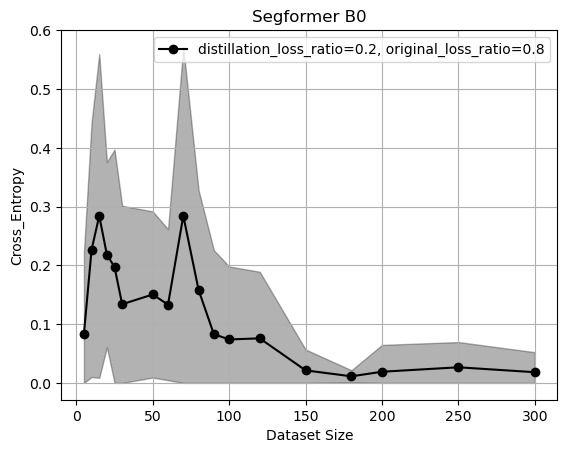

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()